# Stack Overflow Developer Survey 2017–2022 Analysis

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import defaultdict
from forex_python.converter import CurrencyRates

## Set Pandas and matplotlib options

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
pd.set_option('display.max_seq_items', 150)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

## Read in the datasets

In [4]:
years = range(2017, 2023)
survey = dict.fromkeys(years)
schema = dict.fromkeys(years)

for year in years:
    if year == 2018:
        survey_df = pd.read_csv('./data/2018/survey_results_public.csv', low_memory=False)
    else:
        survey_df = pd.read_csv(f'./data/{year}/survey_results_public.csv')
    survey[year] = survey_df
    schema_df = pd.read_csv(f'./data/{year}/survey_results_schema.csv')
    schema[year] = schema_df

cpi_df = pd.read_excel('./data/Inflation-data.xlsx', sheet_name='ccpi_a')

## Clean the data

In [5]:
def clean_data(df, verbose=False):
    '''
    INPUT:
    df - Pandas dataframe containing data to be cleaned
    verbose - bool indicating if debug info should be printed out
    
    OUTPUT:
    new_df - cleaned dataframe
    '''
    if verbose:
        print(f'# of rows before cleaning: {df.shape[0]}')
    new_df = df.dropna(how='all', subset=df.columns[2:]).reset_index(drop=True)
    if verbose:
        print(f'# of rows after cleaning: {new_df.shape[0]}')
    return new_df

In [6]:
for year in years:
    survey[year] = clean_data(survey[year])

## Examine the data

In [7]:
survey[2017].head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new...",0.00,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stac...,9.00,Desktop; iOS app,At le

In [8]:
schema[2019][schema[2019].Column == 'ConvertedComp'].loc[31, 'QuestionText']

'Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.'

## Calculate compensation

In [9]:
compensation_column_names = pd.DataFrame(columns=['currency', 'total', 'frequency'], index=[*range(2018,2023)])
compensation_column_names.loc[2018, :] = ['CurrencySymbol', 'Salary', 'SalaryType']
compensation_column_names.loc[2019, :] = ['CurrencySymbol', 'CompTotal', 'CompFreq']
compensation_column_names.loc[2020, :] = ['CurrencySymbol', 'CompTotal', 'CompFreq']
compensation_column_names.loc[2021, :] = ['Currency', 'CompTotal', 'CompFreq']
compensation_column_names.loc[2022, :] = ['Currency', 'CompTotal', 'CompFreq']
compensation_column_names

,currency,total,frequency
2018,CurrencySymbol,Salary,SalaryType
2019,CurrencySymbol,CompTotal,CompFreq
2020,CurrencySymbol,CompTotal,CompFreq
2021,Currency,CompTotal,CompFreq
2022,Currency,CompTotal,CompFreq


In [10]:
def get_comp_freq(compensation_frequency):
    '''
    INPUT:
    compensation_frequency - string indicating how often is the compensation paid out
    
    OUTPUT:
    multiplier - intiger specifing by which amount is the compensation to be multiplied to obtain yearly amount 
    '''
    if compensation_frequency == 'Yearly':
        multiplier =  1
    elif compensation_frequency == 'Monthly':
        multiplier =  12
    elif compensation_frequency == 'Weekly':
        multiplier =  52
    return multiplier

In [11]:
def calculate_compensation_usd(df, column_names, year, verbose=False):
    '''
    INPUT:
    df - Pandas dataframe containing survey results incl. compensation info
    column_names - Pandas dataframe containing currency, total compensation and its frequency
    year - year in which the survey was conveyed 
    verbose - bool indicating if debug info should be printed out

    OUTPUT:
    new_df - Pandas dataframe containing yearly compensation in USD and country corresponding to the entry 
    '''
    currency = column_names.loc[year, 'currency']
    comp_total = column_names.loc[year, 'total']
    comp_freq = column_names.loc[year, 'frequency']
    comp_df = df[['Country', currency, comp_total, comp_freq]].dropna().reset_index(drop=True)
    
    if verbose:
        print(f'Number of compensation entries without missing values: {comp_df.shape[0]}')
    
    c = CurrencyRates()
    date = datetime.datetime(year, 5, 1)
    rates = c.get_rates('USD', date)
    compensation = []
    
    for idx in range(comp_df.shape[0]):
        currency_code = comp_df.loc[idx, currency][:3]
        freq = get_comp_freq(comp_df.loc[idx, comp_freq])
        comp = comp_df.loc[idx, comp_total]
        if type(comp) == str:
            try:
                comp = float(comp)
            except:
                continue
        if currency_code == 'USD':
            comp_tot = comp * freq
        else:
            if currency_code in rates.keys():
                comp_tot = rates[currency_code] * comp * freq
            else:
                continue
        compensation.append((comp_df.loc[idx, 'Country'], comp_tot))
        
    if verbose:
        print(f'Number of compensation entries with available convertion rates: {len(compensation)}')
    
    new_df = pd.DataFrame(compensation)
    new_df.columns = ['Country', 'Compensation_USD']
        
    return new_df

### Compare compensation with inflation

In [12]:
def comp_vs_cpi(survey, cpi_df, column_names, year):
    '''
    INPUT:
    survey - list of Pandas dataframes containing survey results incl. compensation info
    cpi_df - Pandas dataframe containing CPI values
    column_names - Pandas dataframe containing names of the columns with currency, total compensation and its frequency
    year - year in which the survey was conveyed 

    OUTPUT:
    new_df - Pandas dataframe containing country, median yearly compensation in USD and CPI
    '''
    if year < 2019:
        print('Compensation vs. CPI comparison is only supported from 2018')
        return None
    
    compensation_current_year = calculate_compensation_usd(survey[year], column_names, year)
    compensation_previous_year = calculate_compensation_usd(survey[year-1], column_names, year-1)
    
    median_comp_by_country_current_year = compensation_current_year.groupby('Country')['Compensation_USD'].median().reset_index()
    try:
        idx_uk = median_comp_by_country_current_year.index[median_comp_by_country_current_year['Country'] == 'United Kingdom of Great Britain and Northern Ireland']
        median_comp_by_country_current_year.loc[idx_uk, 'Country'] = 'United Kingdom'
        idx_usa = median_comp_by_country_current_year.index[median_comp_by_country_current_year['Country'] == 'United States of America']
        median_comp_by_country_current_year.loc[idx_usa, 'Country'] = 'United States'
    except:
        pass
    median_comp_by_country_previous_year = compensation_previous_year.groupby('Country')['Compensation_USD'].median().reset_index()
    try:
        idx_uk = median_comp_by_country_previous_year.index[median_comp_by_country_previous_year['Country'] == 'United Kingdom of Great Britain and Northern Ireland']
        median_comp_by_country_previous_year.loc[idx_uk, 'Country'] = 'United Kingdom'
        idx_usa = median_comp_by_country_previous_year.index[median_comp_by_country_previous_year['Country'] == 'United States of America']
        median_comp_by_country_previous_year.loc[idx_usa, 'Country'] = 'United States'
    except:
        pass
    median_comp_by_country = pd.merge(median_comp_by_country_previous_year, median_comp_by_country_current_year, on='Country', suffixes=[f'_{year-1}', f'_{year}'])
    
    cpi_by_country = cpi_df.loc[:, ['Country', year]]
    cpi_by_country.rename(columns={year: f'CPI_{year}'}, inplace=True)
    
    new_df = pd.merge(median_comp_by_country, cpi_by_country, on='Country')
    new_df['Compensation_increase'] = (new_df[f'Compensation_USD_{year}'] - new_df[f'Compensation_USD_{year-1}']) / new_df[f'Compensation_USD_{year-1}'] * 100
    new_df['CPI_vs_increase'] = new_df['Compensation_increase'] - new_df[f'CPI_{year}']
    
    return new_df

In [13]:
raise_vs_cpi = comp_vs_cpi(survey, cpi_df, compensation_column_names, 2021)

Select countries with most respondents

In [15]:
top_countries = survey[2021]['Country'].value_counts()[:10]
top_countries.rename(index={'United States of America': 'United States', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom'}, inplace=True)
top_countries.rename('Count', inplace=True)
top_countries

United States     15288
India             10511
Germany            5625
United Kingdom     4475
Canada             3012
France             2708
Brazil             2254
Poland             1805
Netherlands        1772
Italy              1666
Name: Count, dtype: int64

In [16]:
raise_vs_cpi_top = raise_vs_cpi[raise_vs_cpi['Country'].isin(top_countries.index.tolist())].merge(top_countries, left_on='Country', right_index=True).sort_values('Count', ascending=False)

Visualize copmensation versus inflation

In [17]:
raise_vs_cpi_top.style.format(precision=2).bar(subset=['CPI_vs_increase'], align='mid', color=['#d65f5f', '#5fba7d'])

,Country,Compensation_USD_2020,Compensation_USD_2021,CPI_2021,Compensation_increase,CPI_vs_increase,Count
80,United States,115000.00,125000.00,3.57,8.70,5.12,15288
28,India,52526259.65,74060172.16,5.93,41.00,35.07,10511
21,Germany,53328.43,49660.65,2.27,-6.88,-9.14,5625
79,United Kingdom,41550.75,41698.84,2.30,0.36,-1.94,4475
6,Canada,124351.98,122102.41,2.30,-1.81,-4.11,3012
20,France,39536.59,37245.49,0.84,-5.79,-6.64,2708
5,Brazil,387705.04,481189.37,5.10,24.11,19.02,2254
55,Poland,500213.31,543903.33,4.10,8.73,4.63,1805
46,Netherlands,49650.61,45687.80,1.91,-7.98,-9.89,1772
33,Italy,29995.86,28141.04,0.74,-6.18,-6.93,1666


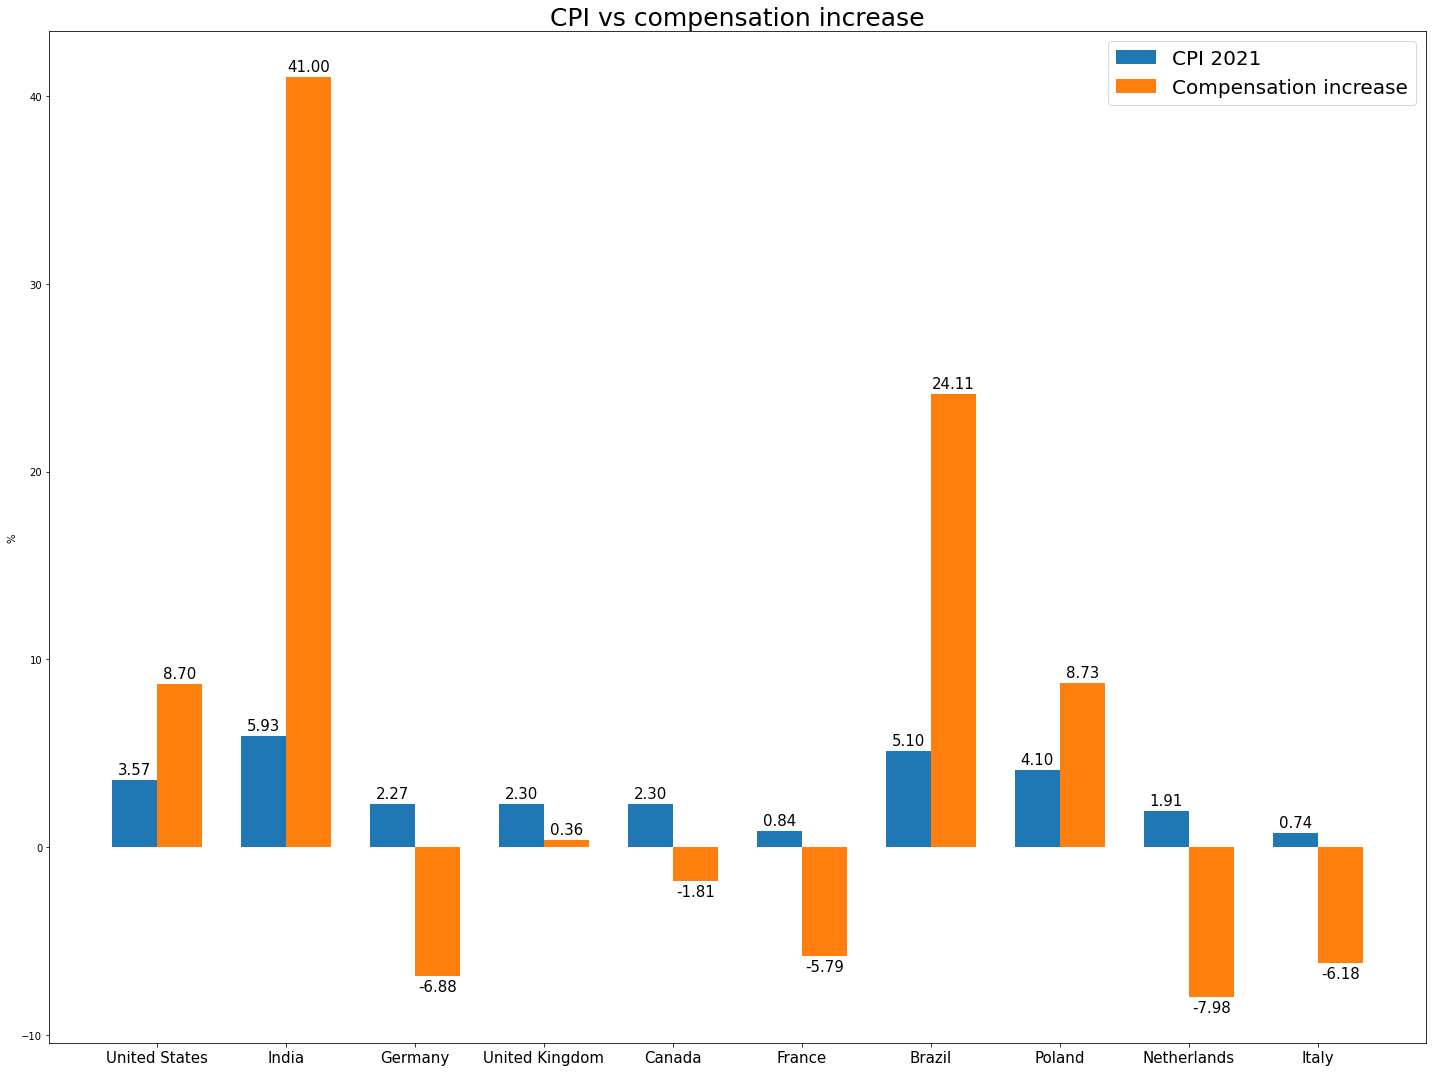

In [18]:
labels = raise_vs_cpi_top['Country']
cpi = raise_vs_cpi_top['CPI_2021']
comp = raise_vs_cpi_top['Compensation_increase']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(20,15))
rects1 = ax.bar(x - width/2, cpi, width, label='CPI 2021')
rects2 = ax.bar(x + width/2, comp, width, label='Compensation increase')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%')
ax.set_title('CPI vs compensation increase', fontsize=25)
ax.set_xticks(x, labels, fontsize=15)
ax.legend(fontsize=20)

ax.bar_label(rects1, padding=3, fmt='%.2f', fontsize=15)
ax.bar_label(rects2, padding=3, fmt='%.2f', fontsize=15)

fig.tight_layout()

plt.show()

## Find most popular programming languages

In [19]:
languages = ['APL', 'Assembly', 'Bash/Shell', 'Bash/Shell/PowerShell', 'C', 'C#', 'C++', 'CoffeeScript', 'Clojure', 'COBOL', 'Crystal',
             'Dart', 'Delphi', 'Elixir', 'Erlang', 'F#', 'Go', 'Groovy', 'Hack', 'Haskell', 'HTML/CSS', 'Java', 'JavaScript', 'Julia',
             'Kotlin', 'LISP', 'Lua', 'MATLAB', 'Node.js', 'Objective-C', 'Perl', 'PHP', 'PowerShell', 'Python', 'R', 'Ruby', 'Rust',
             'Scala', 'Smalltalk', 'SQL', 'Swift', 'TypeScript', 'VBA', 'VB.NET', 'Visual Basic 6', 'WebAssembly']

Select appropiate columns for each year

In [20]:
languages_column_names = pd.DataFrame(columns=['HaveWorkedWith', 'WantToWorkWith'], index=[*range(2017,2023)])
languages_column_names.loc[2017, :] = ['HaveWorkedLanguage', 'WantWorkLanguage']
languages_column_names.loc[2018, :] = ['LanguageWorkedWith', 'LanguageDesireNextYear']
languages_column_names.loc[2019, :] = ['LanguageWorkedWith', 'LanguageDesireNextYear']
languages_column_names.loc[2020, :] = ['LanguageWorkedWith', 'LanguageDesireNextYear']
languages_column_names.loc[2021, :] = ['LanguageHaveWorkedWith', 'LanguageWantToWorkWith']
languages_column_names.loc[2022, :] = ['LanguageHaveWorkedWith', 'LanguageWantToWorkWith']

Most used and wanted languages

In [21]:
def lang_total_count(ser, languages):
    '''
    INPUT:
    ser - Pandas series containing survey results
    languages - list of programming languages

    OUTPUT:
    new_df - a dataframe of each programming language with the count of how often it shows up
    
    CREDIT:
    This function is heavily based and influenced by a similar function namen total_count found
    in the workspace of the first part of the Udacity Data Science Nanodegree 
    '''
    df = ser.value_counts().reset_index()
    df.rename(columns={df.columns[0]: 'language_list', df.columns[1]: 'count'}, inplace=True)
    new_df = defaultdict(int)
    #loop through list
    for lang in list(map(str.lower, languages)):
        #loop through rows
        for idx in range(df.shape[0]):
            #if the language is in the row split string
            if lang in list(map(str.lower, df['language_list'][idx].split(';'))):
                new_df[lang] += int(df['count'][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = ['language', 'count']
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [22]:
languages_most_used = lang_total_count(survey[2022][languages_column_names.loc[2022, 'HaveWorkedWith']], languages)

In [23]:
languages_most_used[:10]

,language,count
19,javascript,46443
17,html/css,39142
34,sql,35127
29,python,34155
36,typescript,24752
18,java,23644
2,bash/shell,20656
4,c#,19883
5,c++,16024
27,php,14827


In [24]:
languages_most_wanted = lang_total_count(survey[2022][languages_column_names.loc[2022, 'WantToWorkWith']], languages)

In [25]:
languages_most_wanted[:10]

,language,count
19,javascript,31551
29,python,29350
36,typescript,26050
17,html/css,25423
34,sql,24804
32,rust,17113
4,c#,15681
14,go,15500
18,java,13345
2,bash/shell,13242


Most loved, dreaded and wanted languages

In [26]:
# Obsolete, use loved_dreaded_wanted function instead
def loved_dreaded_wanted_obs(df, column_names, languages, sort_by='loved_prct'):
    '''
    INPUT:
    df - Pandas dataframe containing survey results
    column_names - Pandas series with the names of the columns containing programming languagages that developer have worked and want to work with
    languages - list of programming languages
    sort_by - string indication by with column should the output dataframe be sorted
    
    OUTPUT:
    new_df - a dataframe with the info on how often the respondends want to continue or start using each programming language and how often they don't
    
    CREDIT:
    This function is heavily based and influenced by a similar function namen total_count found
    in the workspace of the first part of the Udacity Data Science Nanodegree 
    '''
    worked_with_column = column_names['HaveWorkedWith']
    desire_column = column_names['WantToWorkWith']
    look_df = df[[worked_with_column, desire_column]].fillna('No input')
    
    loved = defaultdict(int)
    dreaded = defaultdict(int)
    wanted = defaultdict(int)
    
    #loop through list of languages
    for val in languages:
        #loop through rows of the dataframe
        for idx in range(look_df.shape[0]):
            #if the language is in both columns, add 1 to loved
            if val in look_df[worked_with_column][idx] and val in look_df[desire_column][idx]:
                #if the language is in the row split strings
                langs_worked = look_df[worked_with_column][idx].split(';')
                langs_desire = look_df[desire_column][idx].split(';')
                #check if the language is in the lists
                for lang_worked in langs_worked:
                    if val == lang_worked:
                        for lang_desire in langs_desire:
                            if val == lang_desire:
                                loved[val] += 1
            #if the language is only in the first column, add 1 to dreaded
            if val in look_df[worked_with_column][idx] and val not in look_df[desire_column][idx]:
                #if the language is in the row split string
                langs = look_df[worked_with_column][idx].split(';')
                #check if the language is in the list
                for lang in langs:
                    if val == lang:
                        dreaded[val] += 1
            #if the language is only in the second column, add 1 to wanted
            if val not in look_df[worked_with_column][idx] and val in look_df[desire_column][idx]:
                #if the language is in the row split string
                langs = look_df[desire_column][idx].split(';')
                #check if the language is in the list
                for lang in langs:
                    if val == lang:
                        wanted[val] += 1
                        
    df_loved = pd.DataFrame(pd.Series(loved)).reset_index()
    df_loved.columns = ['language', 'count_loved']
    df_dreaded = pd.DataFrame(pd.Series(dreaded)).reset_index()
    df_dreaded.columns = ['language', 'count_dreaded']
    df_wanted = pd.DataFrame(pd.Series(wanted)).reset_index()
    df_wanted.columns = ['language', 'count_wanted']
    
    new_df = df_loved.merge(df_dreaded, on='language').merge(df_wanted, on='language').set_index('language')
    new_df['loved_prct'] = new_df['count_loved'] / (new_df['count_loved'] + new_df['count_dreaded']) * 100
    new_df['dreaded_prct'] = new_df['count_dreaded'] / (new_df['count_loved'] + new_df['count_dreaded']) * 100
    new_df['wanted_prct'] = new_df['count_wanted'] / (df.shape[0] - new_df['count_loved'] - new_df['count_dreaded']) * 100
    new_df.sort_values(sort_by, ascending=False, inplace=True)
    
    return new_df

In [27]:
def loved_dreaded_wanted(df, column_names, languages, sort_by='loved_prct'):
    '''
    INPUT:
    df - Pandas dataframe containing survey results
    column_names - Pandas series with the names of the columns containing programming languagages that developer have worked and want to work with
    languages - list of programming languages
    sort_by - string indication by with column should the output dataframe be sorted
    
    OUTPUT:
    new_df - a dataframe with the info on how often the respondends want to continue or start using each programming language and how often they don't
    
    CREDIT:
    This function is heavily based and influenced by a similar function namen total_count found
    in the workspace of the first part of the Udacity Data Science Nanodegree 
    '''    
    worked_with_column = column_names['HaveWorkedWith']
    desire_column = column_names['WantToWorkWith']
    look_df = df[[worked_with_column, desire_column]].fillna('No input')
    
    loved = defaultdict(int)
    dreaded = defaultdict(int)
    wanted = defaultdict(int)
    
    #loop through list of languages
    for lang in list(map(str.lower, languages)):
        #loop through rows of the dataframe
        for idx in range(look_df.shape[0]):
            #split strings from both columns into list 
            langs_worked = list(map(str.lower, look_df[worked_with_column][idx].split(';')))
            langs_desire = list(map(str.lower, look_df[desire_column][idx].split(';')))
            langs_both = set(langs_worked).intersection(langs_desire)
            langs_only_worked = set(langs_worked).difference(langs_desire)
            langs_only_desire = set(langs_desire).difference(langs_worked)
            
            #if the language is in both lists, add 1 to loved
            if lang in langs_both:
                loved[lang] += 1
            #if the language is only in the first list, add 1 to dreaded
            if lang in langs_only_worked:
                dreaded[lang] += 1
            #if the language is only in the second list, add 1 to wanted
            if lang in langs_only_desire:
                wanted[lang] += 1
                        
    df_loved = pd.DataFrame(pd.Series(loved)).reset_index()
    df_loved.columns = ['language', 'count_loved']
    df_dreaded = pd.DataFrame(pd.Series(dreaded)).reset_index()
    df_dreaded.columns = ['language', 'count_dreaded']
    df_wanted = pd.DataFrame(pd.Series(wanted)).reset_index()
    df_wanted.columns = ['language', 'count_wanted']
    
    new_df = df_loved.merge(df_dreaded, on='language').merge(df_wanted, on='language').set_index('language')
    new_df['loved_prct'] = new_df['count_loved'] / (new_df['count_loved'] + new_df['count_dreaded']) * 100
    new_df['dreaded_prct'] = new_df['count_dreaded'] / (new_df['count_loved'] + new_df['count_dreaded']) * 100
    new_df['wanted_prct'] = new_df['count_wanted'] / (df.shape[0] - new_df['count_loved'] - new_df['count_dreaded']) * 100
    new_df.sort_values(sort_by, ascending=False, inplace=True)
    
    return new_df

In [28]:
languages_ldw = loved_dreaded_wanted(survey[2022], languages_column_names.loc[2022, :], languages, sort_by='wanted_prct')

In [29]:
languages_ldw

,count_loved,count_dreaded,count_wanted,loved_prct,dreaded_prct,wanted_prct
language,,,,,,
rust,5746,879,11367,86.73,13.27,17.45
python,22999,11156,6351,67.34,32.66,16.88
typescript,18183,6569,7867,73.46,26.54,16.73
go,5116,2806,10384,64.58,35.42,16.26
javascript,28544,17899,3007,61.46,38.54,11.87
kotlin,4118,2389,5198,63.29,36.71,7.96
c++,7754,8270,4142,48.39,51.61,7.43
sql,22568,12559,2236,64.25,35.75,6.10
c#,12603,7280,3078,63.39,36.61,5.93


### Replace count with position

In [30]:
languages_most_used[:10].copy().reset_index(drop=True).reset_index().set_index('language').drop('count', axis='columns').rename(columns={'index': 2022}) + 1

,2022
language,
javascript,1
html/css,2
sql,3
python,4
typescript,5
java,6
bash/shell,7
c#,8
c++,9


In [31]:
def create_chart_df(survey, languages_column_names, languages, sort_by_year):
    '''
    INPUT:
    list of Pandas dataframes containing survey results
    languages_column_names - Pandas series with the names of the columns containing programming languagages
    languages - list of programming languages
    sort_by_year - an intiger indication by with column should the output dataframe be sorted
    
    OUTPUT:
    chart - a dataframe with the position corresponding to how popular each language was each year
    '''
    new_df = lang_total_count(survey[2017][languages_column_names.loc[2017, 'HaveWorkedWith']], languages)
    chart = new_df.copy().reset_index(drop=True).reset_index().set_index('language').drop('count', axis='columns').rename(columns={'index': 2017}) + 1
    for year in range(2018, 2023):
        year_df = lang_total_count(survey[year][languages_column_names.loc[year, 'HaveWorkedWith']], languages)
        new_df = new_df.merge(year_df, on='language', how='outer', suffixes=[f'_{year-1}', f'_{year}'])
        year_pos_df = year_df.copy().reset_index(drop=True).reset_index().set_index('language').drop('count', axis='columns').rename(columns={'index': year}) + 1
        chart = chart.merge(year_pos_df, left_index=True, right_index=True, how='outer', suffixes=[f'_{year-1}', f'_{year}'])
    new_df = new_df.set_index('language').sort_values(f'count_{sort_by_year}', ascending=False)
    chart.sort_values(sort_by_year, inplace=True)
    return chart

In [32]:
chart = create_chart_df(survey, languages_column_names, languages, 2022)

In [33]:
chart[:10]

,2017,2018,2019,2020,2021,2022
language,,,,,,
javascript,3.00,1.00,1.00,1.00,1.00,1.00
html/css,NaN,NaN,2.00,2.00,2.00,2.00
sql,13.00,2.00,3.00,3.00,4.00,3.00
python,7.00,5.00,4.00,4.00,3.00,4.00
typescript,32.00,10.00,10.00,9.00,7.00,5.00
java,2.00,3.00,5.00,5.00,5.00,6.00
bash/shell,NaN,4.00,NaN,NaN,9.00,7.00
c#,1.00,6.00,7.00,7.00,8.00,8.00
c++,5.00,8.00,9.00,10.00,10.00,9.00
